In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, DMatrix
from bayes_opt import BayesianOptimization
import scipy.interpolate
import time
import xgboost as xgb
from pylightgbm.models import GBMRegressor

# Visualization options
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
display(HTML("<style>.container { width: 90% !important; }</style>"))
warnings.filterwarnings("ignore")

# Global variables
SEED = 420
N_JOBS = 18
FOLDS = 5
os.environ["LIGHTGBM_EXEC"] = "C:/Users/Julien/LightGBM/lightgbm.exe"


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def run_model(model) : 
    # Define train and test sets for BO process
    oof_preds = pd.DataFrame()
    oof_targets = pd.DataFrame()
    kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
       
        # Fit model
        model.fit(X_train, y_train)

        # Compute score on this fold
        preds_val = model.predict(X_val)    
        
        # Store OOF predictions
        oof_preds = pd.concat([pd.Series(oof_preds), pd.Series(preds_val)], axis = 0)
        oof_targets = pd.concat([pd.Series(oof_targets), pd.Series(y_val.y)], axis = 0)
    
    # Compte error on OOF predictions
    cv_score = r2_score(oof_targets, oof_preds)

    return(cv_score)
    

In [3]:
def run_rf(max_features, max_depth, min_samples_split, min_samples_leaf) :
    rf = RandomForestRegressor(n_estimators = 200, 
                               max_features = max_features,
                               max_depth = int(max_depth), 
                               min_samples_split = int(min_samples_split), 
                               min_samples_leaf = int(min_samples_leaf), 
                               n_jobs = N_JOBS, 
                               random_state = SEED)
    return(run_model(rf))

def run_et(max_features, max_depth, min_samples_split, min_samples_leaf) :
    et = ExtraTreesRegressor(n_estimators = 200, 
                             max_features = max_features, 
                             max_depth = int(max_depth), 
                             min_samples_split = int(min_samples_split), 
                             min_samples_leaf = int(min_samples_leaf), 
                             n_jobs = N_JOBS, 
                             random_state = SEED)
    return(run_model(et))

def run_xgb(max_depth, min_child_weight, subsample, colsample_bytree, colsample_bylevel) :
    xg = XGBRegressor(objective = "reg:linear", 
                      learning_rate = 0.01, 
                      n_estimators = 750, 
                      max_depth = int(max_depth), 
                      min_child_weight = int(min_child_weight), 
                      subsample = subsample, 
                      colsample_bytree = colsample_bytree, 
                      colsample_bylevel = colsample_bylevel, 
                      nthread = N_JOBS,
                      seed = SEED)
    return(run_model(xg))

def run_lgbm(min_data_in_leaf, feature_fraction, bagging_fraction, bagging_freq, max_depth) :
    lg = GBMRegressor(tree_learner = "serial", 
                      application = "regression", 
                      metric = "l2",
                      learning_rate = 0.2,
                      num_iterations = 800, 
                      min_data_in_leaf = int(min_data_in_leaf), 
                      feature_fraction = feature_fraction,
                      feature_fraction_seed = SEED,
                      bagging_fraction = bagging_fraction,
                      bagging_freq = int(bagging_freq),
                      bagging_seed = SEED,
                      max_depth = int(max_depth),
                      num_threads = N_JOBS,
                      verbose = False,)
    return(run_model(lg))


In [4]:
rf_max_features_min = 0.3
rf_max_features_max = 1.0
rf_max_depth_min = 4
rf_max_depth_max = 8
rf_min_samples_split_min = 2
rf_min_samples_split_max = 20
rf_min_samples_leaf_min = 2
rf_min_samples_leaf_max = 20

et_max_features_min = 0.3
et_max_features_max = 1.0
et_max_depth_min = 3
et_max_depth_max = 10
et_min_samples_split_min = 2
et_min_samples_split_max = 20
et_min_samples_leaf_min = 2
et_min_samples_leaf_max = 20

xgb_max_depth_min = 3
xgb_max_depth_max = 6
xgb_min_child_weight_min = 5
xgb_min_child_weight_max = 15
xgb_subsample_min = 0.7
xgb_subsample_max = 1.0
xgb_colsample_bytree_min = 0.3
xgb_colsample_bytree_max = 1.0
xgb_colsample_bylevel_min = 0.3
xgb_colsample_bylevel_max = 1.0

lg_min_data_in_leaf_min = 2
lg_min_data_in_leaf_max = 15
lg_feature_fraction_min = 0.2
lg_feature_fraction_max = 0.4
lg_bagging_fraction_min = 1.0
lg_bagging_fraction_max = 1.0
lg_bagging_freq_min = 5
lg_bagging_freq_max = 50
lg_max_depth_min = 3
lg_max_depth_max = 5


In [5]:
# Init Bayesian Optimization
def initBO() :
    if (MODEL == "rf") :
        # Define the features to explore
        bo = BayesianOptimization(run_et, {
            "max_features" : (rf_max_features_min, rf_max_features_max), 
            "max_depth" : (rf_max_depth_min, rf_max_depth_max),
            "min_samples_split" : (rf_min_samples_split_min, rf_min_samples_split_max),
            "min_samples_leaf" : (rf_min_samples_leaf_min, rf_min_samples_leaf_max),
        })
        
        # Define the initial exploration : 10 points approximately covering the range of each parameter
        bo.explore({
            "max_features" : [0.8, 0.9, 0.5, 0.6, 0.4, 1.0, 0.7, 0.5, 0.6, 0.3],
            "max_depth" : [4, 6, 5, 8, 4, 8, 7, 6, 5, 4], 
            "min_samples_split" : [5, 2, 10, 3, 20, 8, 4, 14, 12, 6],
            "min_samples_leaf" : [4, 10, 12, 8, 2, 5, 14, 3, 12, 20]
        })
    elif (MODEL == "et") :
        # Define the features to explore
        bo = BayesianOptimization(run_et, {
            "max_features" : (et_max_features_min, et_max_features_max), 
            "max_depth" : (et_max_depth_min, et_max_depth_max),
            "min_samples_split" : (et_min_samples_split_min, et_min_samples_split_max),
            "min_samples_leaf" : (et_min_samples_leaf_min, et_min_samples_leaf_max),
        })
        
        # Define the initial exploration : 10 points approximately covering the range of each parameter
        bo.explore({
            "max_features" : [0.8, 0.9, 0.5, 0.6, 0.4, 1.0, 0.7, 0.5, 0.6, 0.3],
            "max_depth" : [3, 6, 5, 10, 4, 8, 7, 6, 5, 4], 
            "min_samples_split" : [5, 2, 10, 3, 20, 8, 4, 14, 12, 6],
            "min_samples_leaf" : [4, 10, 12, 8, 2, 5, 14, 3, 12, 20]
        })
    elif (MODEL == "xg") :
        # Define the features to explore
        bo = BayesianOptimization(run_xgb, {
            "max_depth" : (xgb_max_depth_min, xgb_max_depth_max), 
            "min_child_weight" : (xgb_min_child_weight_min, xgb_min_child_weight_max),
            "subsample" : (xgb_subsample_min, xgb_subsample_max),
            "colsample_bytree" : (xgb_colsample_bytree_min, xgb_colsample_bytree_max),
            "colsample_bylevel" : (xgb_colsample_bylevel_min, xgb_colsample_bylevel_max), 
        })
        
        # Define the initial exploration : 10 points approximately covering the range of each parameter
        bo.explore({
            "max_depth" : [5, 3, 6, 3, 6, 4, 5, 3, 5, 4],
            "min_child_weight" : [5, 10, 7, 5, 12, 15, 8, 6, 7, 14],
            "subsample" : [0.7, 0.75, 0.7, 0.8, 0.85, 1.0, 0.9, 0.95, 0.8, 1.0],
            "colsample_bytree" : [0.4, 0.7, 1.0, 0.6, 0.3, 0.5, 0.8, 0.6, 0.8, 0.9], 
            "colsample_bylevel" :  [0.8, 0.6, 0.7, 0.3, 0.6, 0.9, 1.0, 0.5, 0.7, 0.4],
            })
    elif (MODEL == "lg") :
        # Define the features to explore
        bo = BayesianOptimization(run_lgbm, {
            "min_data_in_leaf" : (lg_min_data_in_leaf_min, lg_min_data_in_leaf_max), 
            "feature_fraction" : (lg_feature_fraction_min, lg_feature_fraction_max),
            "bagging_fraction" : (lg_bagging_fraction_min, lg_bagging_fraction_max),
            "bagging_freq" : (lg_bagging_freq_min, lg_bagging_freq_max),
            "max_depth" : (lg_max_depth_min, lg_max_depth_max), 
        })
        
        # Define the initial exploration : 10 points approximately covering the range of each parameter
        bo.explore({
            "min_data_in_leaf" : [5, 14, 12, 5, 3, 8, 2, 7, 15, 10],
            "feature_fraction" : [0.2, 0.4, 0.25, 0.35, 0.3, 0.2, 0.25, 0.3, 0.35, 0.4],
            "bagging_fraction" : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
            "bagging_freq" : [20, 25, 5, 50, 40, 10, 30, 35, 10, 15], 
            "max_depth" :  [3, 5, 5, 4, 3, 3, 4, 3, 5, 5],
            })
    
    return(bo)

In [6]:
# Plot results of optimization
def graphBO(history_df, param1, param2, param1min, param1max, param2min, param2max, ratio) :
    x, y, z = history_df[param1].values, history_df[param2].values, history_df["RMSE"].values

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(param1min, param1max, 100), np.linspace(param2min, param2max, 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function = "multiquadric", smooth = 0.5)
    zi = rbf(xi, yi)

    plt.figure()
    plt.imshow(zi, 
               cmap = "plasma", 
               aspect = ratio,
               vmin = z.min(), 
               vmax = z.max(), 
               origin = "lower",
               extent = [param1min, param1max, param2min, param2max])
    q = plt.scatter(x, y, c = z, cmap = "plasma")
    plt.colorbar(q)
    plt.xlabel(param1)
    plt.ylabel(param2)
    #plt.savefig("figures/XGB_" + param1 + "_" + param2 + ".png")
    plt.show(block = False)

<b>Script</b>

In [7]:
# Get data
train = pd.read_csv("raw_data/train.csv")
test = pd.read_csv("raw_data/test.csv")
display(train.shape)
display(train.head(2))


(4209, 378)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81000,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53000,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [8]:
# Config data
train.y = np.log(train.y + 10)

vars = ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]
for i in range(len(vars)) :
    col = vars[i]
    y_x = train[[col, "y"]].groupby([col], as_index = False).mean()
    y_x.columns = [col, "y_" + col]

    train = pd.merge(train, y_x, on = col, how = "outer")
    train.sort_values(["ID"], ascending = True, inplace = True)
    train.reset_index(drop = True, inplace = True)

constant_vars = []
for col in train.drop("y", axis = 1).columns:
    if(train[col].nunique() == 1):
        constant_vars.append(col)
train.drop(constant_vars, axis = 1, inplace = True)

for c in train.drop("y", axis = 1).columns:
    if train[c].dtype == "object" :
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))

binary_vars = list(set(train.columns.drop(["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"])))
train["bin_ones"] = (train[binary_vars] == 1).astype(int).sum(axis = 1)

train.sort_index(axis = 1, inplace = True)
y = pd.DataFrame({"y": train.y})
train.drop("y", axis = 1, inplace = True)

In [9]:
# Run optimization
MODEL = "lg"
start = time.time()
bo = initBO()
bo.maximize(init_points = 10, n_iter = 150)
print("BayesianOptimization took %.2f seconds" % ((time.time() - start)))

Initialization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   max_depth |   min_data_in_leaf | 
    1 | 00m08s |    0.60921 |             1.0000 |        20.0000 |             0.2000 |      3.0000 |             5.0000 | 
    2 | 00m15s |    0.54354 |             1.0000 |        25.0000 |             0.4000 |      5.0000 |            14.0000 | 
    3 | 00m14s |    0.55373 |             1.0000 |         5.0000 |             0.2500 |      5.0000 |            12.0000 | 
    4 | 00m11s |    0.56886 |             1.0000 |        50.0000 |             0.3500 |      4.0000 |             5.0000 | 
    5 | 00m08s |    0.60707 |             1.0000 |        40.0000 |             0.3000 |      3.0000 |             3.0000 | 
    6 | 00m08s |    0.60921 |             1.0000 |        10.0000 |             0.2000 |      3.0000 |         

KeyboardInterrupt: 

In [10]:
# Store and look at results
history_df = pd.DataFrame(bo.res["all"]["params"])
history_df2 = pd.DataFrame(bo.res["all"]["values"])
history_df = pd.concat((history_df, history_df2), axis = 1)
history_df.rename(columns = { 0 : "RMSE"}, inplace = True)
history_df.index.names = ["Iteration"]
history_df.sort_values(["RMSE"], ascending = False, inplace = True)
#history_df.to_csv("../../data/temp_results/bo.csv")
display(history_df.head(10))

,bagging_fraction,bagging_freq,feature_fraction,max_depth,min_data_in_leaf,RMSE
Iteration,,,,,,
27,1.00000,46.67375,0.20000,3.33949,14.95231,0.61064
6,1.00000,50.00000,0.20000,3.00000,15.00000,0.61064
28,1.00000,47.08722,0.20000,3.00000,14.14830,0.61064
48,1.00000,5.00000,0.20000,3.00000,15.00000,0.61064
23,1.00000,43.71783,0.20000,3.00000,14.94581,0.61064
51,1.00000,39.53022,0.20000,3.00000,14.80602,0.61064
54,1.00000,14.33269,0.20000,3.00000,14.47596,0.61064
55,1.00000,10.76010,0.20000,3.00000,14.54973,0.61064
2,1.00000,41.32406,0.20000,3.00000,14.71451,0.61064


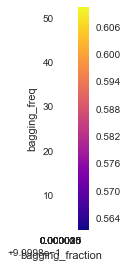

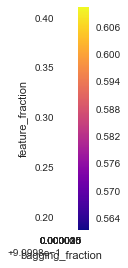

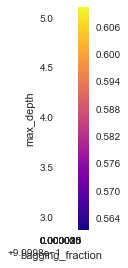

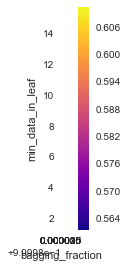

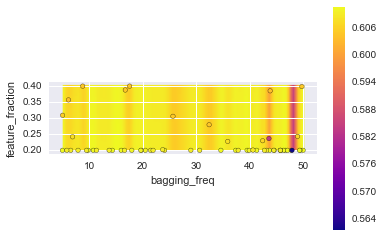

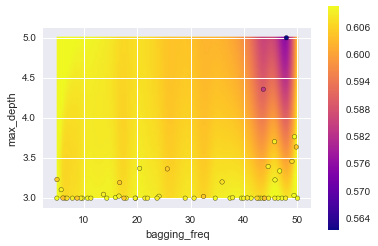

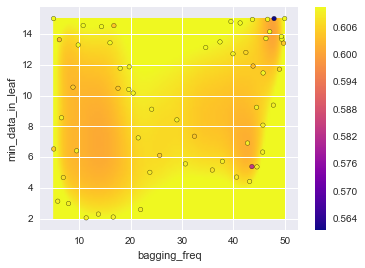

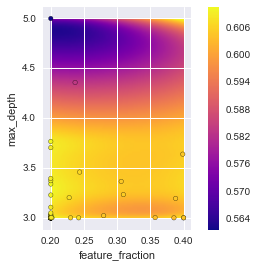

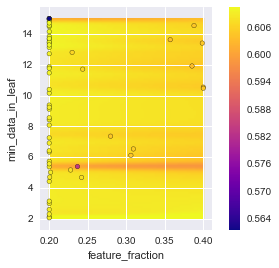

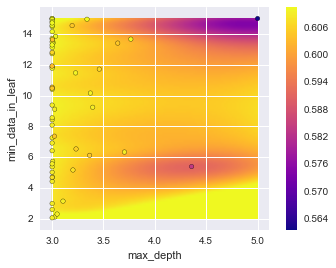

In [16]:
if (MODEL == "rf") :
    graphBO(history_df, "max_features", "max_depth", rf_max_features_min, rf_max_features_max, rf_max_depth_min, rf_max_depth_max, 0.15)
    graphBO(history_df, "max_features", "min_samples_split", rf_max_features_min, rf_max_features_max, rf_min_samples_split_min, rf_min_samples_split_max, 0.03)
    graphBO(history_df, "max_features", "min_samples_leaf", rf_max_features_min, rf_max_features_max, rf_min_samples_leaf_min, rf_min_samples_leaf_max, 0.03)
    graphBO(history_df, "max_depth", "min_samples_split", rf_max_depth_min, rf_max_depth_max, rf_min_samples_split_min, rf_min_samples_split_max, 0.2)
    graphBO(history_df, "max_depth", "min_samples_leaf", rf_max_depth_min, rf_max_depth_max, rf_min_samples_leaf_min, rf_min_samples_leaf_max, 0.2)
    graphBO(history_df, "min_samples_split", "min_samples_leaf", rf_min_samples_split_min, rf_min_samples_split_max, rf_min_samples_leaf_min, rf_min_samples_leaf_max, 0.8)
elif (MODEL == "et") :
    graphBO(history_df, "max_features", "max_depth", et_max_features_min, et_max_features_max, et_max_depth_min, et_max_depth_max, 0.1)
    graphBO(history_df, "max_features", "min_samples_split", et_max_features_min, et_max_features_max, et_min_samples_split_min, et_min_samples_split_max, 0.04)
    graphBO(history_df, "max_features", "min_samples_leaf", et_max_features_min, et_max_features_max, et_min_samples_leaf_min, et_min_samples_leaf_max, 0.04)
    graphBO(history_df, "max_depth", "min_samples_split", et_max_depth_min, et_max_depth_max, et_min_samples_split_min, et_min_samples_split_max, 0.4)
    graphBO(history_df, "max_depth", "min_samples_leaf", et_max_depth_min, et_max_depth_max, et_min_samples_leaf_min, et_min_samples_leaf_max, 0.4)
    graphBO(history_df, "min_samples_split", "min_samples_leaf", et_min_samples_split_min, et_min_samples_split_max, et_min_samples_leaf_min, et_min_samples_leaf_max, 0.8)
elif (MODEL == "xg") :
    graphBO(history_df, "max_depth", "min_child_weight", xgb_max_depth_min, xgb_max_depth_max, xgb_min_child_weight_min, xgb_min_child_weight_max, 0.3)
    graphBO(history_df, "max_depth", "subsample", xgb_max_depth_min, xgb_max_depth_max, xgb_subsample_min, xgb_subsample_max, 8)
    graphBO(history_df, "max_depth", "colsample_bytree", xgb_max_depth_min, xgb_max_depth_max, xgb_colsample_bytree_min, xgb_colsample_bytree_max, 3)
    graphBO(history_df, "max_depth", "colsample_bylevel", xgb_max_depth_min, xgb_max_depth_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 3)
    graphBO(history_df, "min_child_weight", "subsample", xgb_min_child_weight_min, xgb_min_child_weight_max, xgb_subsample_min, xgb_subsample_max, 25)
    graphBO(history_df, "min_child_weight", "colsample_bytree", xgb_min_child_weight_min, xgb_min_child_weight_max, xgb_colsample_bytree_min, xgb_colsample_bytree_max, 15)
    graphBO(history_df, "min_child_weight", "colsample_bylevel", xgb_min_child_weight_min, xgb_min_child_weight_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 15)
    graphBO(history_df, "subsample", "colsample_bytree", xgb_subsample_min, xgb_subsample_max, xgb_colsample_bytree_min, xgb_colsample_bytree_max, 0.4)
    graphBO(history_df, "subsample", "colsample_bylevel", xgb_subsample_min, xgb_subsample_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 0.4)
    graphBO(history_df, "colsample_bytree", "colsample_bylevel", xgb_colsample_bytree_min, xgb_colsample_bytree_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 1)
elif (MODEL == "lg") :
    graphBO(history_df, "bagging_fraction", "bagging_freq", lg_bagging_fraction_min, lg_bagging_fraction_max, lg_bagging_freq_min, lg_bagging_freq_max, 0.1)
    graphBO(history_df, "bagging_fraction", "feature_fraction", lg_bagging_fraction_min, lg_bagging_fraction_max, lg_feature_fraction_min, lg_feature_fraction_max, 0.8)
    graphBO(history_df, "bagging_fraction", "max_depth", lg_bagging_fraction_min, lg_bagging_fraction_max, lg_max_depth_min, lg_max_depth_max, 0.2)
    graphBO(history_df, "bagging_fraction", "min_data_in_leaf", lg_bagging_fraction_min, lg_bagging_fraction_max, lg_min_data_in_leaf_min, lg_min_data_in_leaf_max, 0.03)
    graphBO(history_df, "bagging_freq", "feature_fraction", lg_bagging_freq_min, lg_bagging_freq_max, lg_feature_fraction_min, lg_feature_fraction_max, 60)
    graphBO(history_df, "bagging_freq", "max_depth", lg_bagging_freq_min, lg_bagging_freq_max, lg_max_depth_min, lg_max_depth_max, 15)
    graphBO(history_df, "bagging_freq", "min_data_in_leaf", lg_bagging_freq_min, lg_bagging_freq_max, lg_min_data_in_leaf_min, lg_min_data_in_leaf_max, 3)
    graphBO(history_df, "feature_fraction", "max_depth", lg_feature_fraction_min, lg_feature_fraction_max, lg_max_depth_min, lg_max_depth_max, 0.15)
    graphBO(history_df, "feature_fraction", "min_data_in_leaf", lg_feature_fraction_min, lg_feature_fraction_max, lg_min_data_in_leaf_min, lg_min_data_in_leaf_max, 0.02)
    graphBO(history_df, "max_depth", "min_data_in_leaf", lg_max_depth_min, lg_max_depth_max, lg_min_data_in_leaf_min, lg_min_data_in_leaf_max, 0.15)
